In [1]:
!pip install pytorch-lightning
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 543.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

Import libraries and dependencies

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets as dsets

from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import numpy as np

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
import random

from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
import pytorch_lightning as pl

import os
import shutil
import random
import imageio

import numpy as np
from PIL import Image
import cv2


from pytorch_lightning.loggers import WandbLogger

from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

from tqdm import tqdm
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [26]:
from pytorch_lightning.callbacks import TQDMProgressBar

Load Dataset

In [3]:
!pip install gdown
!gdown --fuzzy https://drive.google.com/file/d/1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
From (redirected): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx&confirm=t&uuid=30456efa-e9d8-4656-9924-d9eb7595a362
To: /content/real_hst.zip
100% 80.5M/80.5M [00:00<00:00, 213MB/s]


In [4]:
# Extract the downloaded zip file into the /content directory
!unzip -q /$(pwd)/real_hst.zip -d /$(pwd)/

# Remove the downloaded zip file (optional)
!rm /$(pwd)/real_hst.zip

In [5]:
current_directory = os.getcwd()

# Define paths
input_folder =current_directory+'/real_hst/'  # Path to folder containing .npy files
output_folder =current_directory+'/real_hst_2/'  # Path to folder to save .jpg files

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all .npy files in the input folder
npy_files = [f for f in os.listdir(input_folder) if f.endswith('.npy')]

# Convert each .npy file to .jpg
for npy_file in npy_files:
    # Load the .npy file
    npy_path = os.path.join(input_folder, npy_file)
    img_array = np.load(npy_path)
    #img_array = img_array.astype(np.uint32)
    new_p = Image.fromarray(img_array*32)
    new_p = new_p.convert("RGB")

    # Save the image as .jpg
    jpg_file = os.path.splitext(npy_file)[0] + '.jpg'
    jpg_path = os.path.join(output_folder, jpg_file)
    new_p.save(jpg_path)

print("Conversion complete.")

# Define paths
source_folder = current_directory+'/real_hst_2/'
train_folder = current_directory+'/ssl_dataset/train/'
test_folder = current_directory+'/ssl_dataset/test/'

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# List files in the source folder
files = os.listdir(source_folder)

# Shuffle the files to distribute randomly
random.shuffle(files)

# Calculate split indices
split_index = int(0.9 * len(files))

# Divide files into train and test sets
train_files = files[:split_index]
test_files = files[split_index:]

# Copy files to train folder
for file in train_files:
    source_path = os.path.join(source_folder, file)
    dest_path = os.path.join(train_folder, file)
    shutil.copy(source_path, dest_path)

# Copy files to test folder
for file in test_files:
    source_path = os.path.join(source_folder, file)
    dest_path = os.path.join(test_folder, file)
    shutil.copy(source_path, dest_path)

print("Dataset divided and copied successfully.")

Conversion complete.
Dataset divided and copied successfully.


Set up unlabelled dataset from pictures

In [6]:
class CustomUnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image,None

dataset_train_simclr = CustomUnlabeledDataset(root_dir=train_folder, transform=None)
dataset_test = CustomUnlabeledDataset(root_dir=test_folder, transform=None)

Contrastive Loss

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())

    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

Utility functions for image augmentations

In [8]:
def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(384, 384)):
        self.angle = angle
        self.output_size = output_size

    def angle_to_rad(self, ang): return np.pi * ang / 180.0

    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img

class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges

    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)

Data augmentation wrapper

In [9]:
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, target_size=(384, 384), debug=False):
        super().__init__()
        self.ds = ds
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")


        self.preprocess = transforms.Compose([
                transforms.Resize((384, 384)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.33),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ])

    def __len__(self): return len(self.ds)

    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw, _ = self.ds[idx]

        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)

        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)

        return (t1, t2), torch.tensor(0)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)

    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

SS Contrastive Neural Network

In [10]:
class ImageEmbedding(nn.Module):
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x


    def __init__(self, embedding_size=1024):
        super().__init__()

        base_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)
        internal_embedding_size = base_model.head.in_features
        base_model.head = ImageEmbedding.Identity()

        self.embedding = base_model

        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

Set up pytorch lightning training module

In [11]:
class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams):
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        super().__init__()
        self.save_hyperparameters(hparams)
        self.model = ImageEmbedding()
        self.loss = ContrastiveLoss(hparams.batch_size)

    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs

    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(dataset_train_simclr,
                                             debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size,
                          num_workers=cpu_count(),
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                         drop_last=True)

    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(dataset_test,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size,
                          shuffle=False,
                          num_workers=cpu_count(),
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                         drop_last=True)

    def forward(self, X):
        return self.model(X)

    def step(self, batch, step_name = "train"):
        (X, Y), y = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        loss = self.loss(projectionX, projectionY)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        if step_name == "train":
            self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        else:
            self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        return [optimizer], []
    def on_epoch_start(self):
        print('\n')

Hyperparameters

In [12]:
from argparse import Namespace
hparams = Namespace(
    lr=1e-5,
    epochs=110,
    batch_size=20,
    train_size=len(dataset_train_simclr),
    validation_size=len(dataset_test)
)

Training: Learn embeddings

In [13]:


module = ImageEmbeddingModule(hparams)
trainer = pl.Trainer(max_epochs=hparams.epochs,callbacks=RichProgressBar(leave=True))
trainer.fit(module)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Plea

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ ImageEmbedding  │ 87.9 M │
│ 1 │ loss  │ ContrastiveLoss │      0 │
└───┴───────┴─────────────────┴────────┘

Trainable params: 87.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 87.9 M                                                                                               
Total estimated model params size (MB): 351

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9)
is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you 
want to see logs for the training epoch.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=110` reached.


Save embedding model

In [14]:
checkpoint_file = "deit-embeddings.ckpt"
trainer.save_checkpoint(checkpoint_file)

Generate embedding to visualize classification with clustering algorithm

In [15]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


emb_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

])

#source_directory = os.path.join(current_directory, 'ssl_dataset', 'test')


#module.eval()

#embeddings, filenames = generate_embeddings(module, CustomUnlabeledDataset(root_dir=test_folder, transform=emb_transform))

Cluster into two categories using knn

In [16]:
from sklearn.cluster import KMeans

def cluster_embeddings(embeddings, filenames, N):
    """
    Cluster filenames based on vector embeddings using KMeans clustering.

    Args:
        embeddings (list): List of vector embeddings.
        filenames (list): List of corresponding filenames.
        N (int): Number of clusters.

    Returns:
        list: N lists containing the filenames clustered per group.
    """
    # Perform clustering using KMeans algorithm
    kmeans = KMeans(n_clusters=N)
    clusters = kmeans.fit_predict(embeddings)

    # Initialize lists to store filenames per cluster
    clustered_filenames = [[] for _ in range(N)]

    # Assign filenames to clusters
    for filename, cluster_id in zip(filenames, clusters):
        clustered_filenames[cluster_id].append(filename)

    return clustered_filenames

#print(cluster_embeddings(embeddings, filenames, 2))

Alternatively we sort the val dataset into categories, place a classifer and run a regular classification

Sort into categories/labels

In [17]:
current_directory = os.getcwd()

# Define source and destination directories for train and test folders
source_directories = [os.path.join(current_directory, 'ssl_dataset', 'train'),
                      os.path.join(current_directory, 'ssl_dataset', 'test')]
destination_lens_directories = [os.path.join(directory, 'lens') for directory in source_directories]
destination_no_lens_directories = [os.path.join(directory, 'no_lens') for directory in source_directories]

# Create destination directories if they don't exist
for directory in destination_lens_directories + destination_no_lens_directories:
    os.makedirs(directory, exist_ok=True)

# Iterate over train and test folders
for source_directory, destination_lens_directory, destination_no_lens_directory in zip(source_directories, destination_lens_directories, destination_no_lens_directories):
    # Copy files from source to destination directories
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            source_file = os.path.join(root, file)
            destination_dir = destination_no_lens_directory if file.startswith('nl') else destination_lens_directory
            destination_file = os.path.join(destination_dir, file)
            os.makedirs(os.path.dirname(destination_file), exist_ok=True)
            # Check if source and destination paths are different
            if source_file != destination_file:
                shutil.copy(source_file, destination_file)


Create a classifier model; freeze embedding layers

In [18]:
class SimCLRClassifier(nn.Module):
    def __init__(self, n_classes, freeze_base, embeddings_model_path, hidden_size=512):
        super().__init__()

        base_model = ImageEmbeddingModule.load_from_checkpoint(embeddings_model_path).model

        self.embeddings = base_model.embedding

        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False

        # Only linear projection on top of the embeddings should be enough
        self.classifier = nn.Linear(in_features=base_model.projection[0].in_features,
                      out_features=n_classes)


    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)

Classifier Training

In [19]:
class SimCLRClassifierModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.save_hyperparameters(hparams)
        self.model = SimCLRClassifier(hparams.n_classes, hparams.freeze_base,
                                      hparams.embeddings_path,
                                      self.hparams.hidden_size)
        self.loss = nn.CrossEntropyLoss()

    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs

    def preprocessing(seff):
        return transforms.Compose([
                transforms.Resize((384, 384)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def get_dataloader(self, split):
        return DataLoader(dsets.ImageFolder(current_directory+'/ssl_dataset/'+split, transform=self.preprocessing()),
                          batch_size=self.hparams.batch_size,
                          shuffle=split=="train",
                          num_workers=cpu_count(),
                         drop_last=False)

    def train_dataloader(self):
        return self.get_dataloader("train")

    def val_dataloader(self):
        return self.get_dataloader("test")

    def forward(self, X):
        return self.model(X)

    def step(self, batch, step_name = "train"):
        X, y = batch
        y_out = self.forward(X)
        loss = self.loss(y_out, y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        if step_name == "train":
            self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        else:
            self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        "progress_bar": {loss_key: loss}}

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.step(Batch, "test")

    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        schedulers = [
            CosineAnnealingLR(optimizer, self.hparams.epochs)
        ] if self.hparams.epochs > 1 else []
        return [optimizer], schedulers

Train

In [20]:
hparams_cls = Namespace(
    lr=0.0002,
    epochs=40,
    batch_size=20,
    n_classes=2,
    freeze_base=True,
    embeddings_path="./deit-embeddings.ckpt",
    hidden_size=512
)
module = SimCLRClassifierModule(hparams_cls)
trainer = pl.Trainer(max_epochs=hparams_cls.epochs,callbacks=RichProgressBar(leave=True))
trainer.fit(module)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Freezing embeddings


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ SimCLRClassifier │ 86.1 M │
│ 1 │ loss  │ CrossEntropyLoss │      0 │
└───┴───────┴──────────────────┴────────┘

Trainable params: 1.5 K                                                                                            
Non-trainable params: 86.1 M                                                                                       
Total params: 86.1 M                                                                                               
Total estimated model params size (MB): 344

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Evaluate model

In [21]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

In [22]:
_ = evaluate(module.val_dataloader(), module)

              precision    recall  f1-score   support

           0      0.882     1.000     0.938        15
           1      1.000     0.714     0.833         7

    accuracy                          0.909        22
   macro avg      0.941     0.857     0.885        22
weighted avg      0.920     0.909     0.904        22



Save final model

In [23]:
final_checkpoint_file = "deit-classifier.ckpt"
trainer.save_checkpoint(final_checkpoint_file)

Run Evaluation metrics

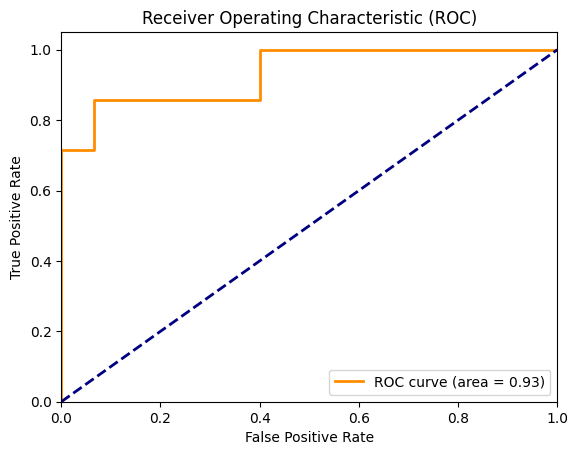

AUC Score: 0.9333333333333333


In [24]:
# Run validation dataset again to construct AUC ROC
module.eval()
y_preds_list = []
y_trues_list = []
with torch.no_grad():
    for batch in module.val_dataloader():
        y_preds = module(batch[0].cuda())
        y_preds_list.append(y_preds.cpu())
        y_trues_list.append(batch[1].cpu())
y_preds = torch.cat(y_preds_list)
y_trues = torch.cat(y_trues_list)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_trues.numpy(), F.softmax(y_preds, dim=1)[:, 1].numpy())

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", auc_score)

Send all to Drive

In [29]:
!mkdir /content/drive/MyDrive/hurray

In [31]:
!cp /content/deit-classifier.ckpt /content/drive/MyDrive/hurray
!cp /content/deit-embeddings.ckpt /content/drive/MyDrive/hurray

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
